In [ ]:
#Importing Libraries
import tensorflow as tf
import numpy as np
import pandas as pd
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import sys
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/content


In [ ]:
!unzip happy.zip

Archive:  happy.zip
   creating: happy/
  inflating: happy/dont stop me now.mid  
  inflating: happy/haydn_33_1.mid    
  inflating: happy/haydn_33_2.mid    
  inflating: happy/haydn_33_3.mid    
  inflating: happy/haydn_35_1.mid    
  inflating: happy/haydn_35_2.mid    
  inflating: happy/haydn_35_3.mid    
  inflating: happy/haydn_43_1.mid    
  inflating: happy/haydn_43_2.mid    
  inflating: happy/haydn_43_3.mid    
  inflating: happy/haydn_7_1.mid     
  inflating: happy/haydn_7_2.mid     
  inflating: happy/haydn_7_3.mid     
  inflating: happy/haydn_8_1.mid     
  inflating: happy/haydn_8_2.mid     
  inflating: happy/haydn_8_3.mid     
  inflating: happy/haydn_8_4.mid     
  inflating: happy/haydn_9_1.mid     
  inflating: happy/haydn_9_2.mid     
  inflating: happy/haydn_9_3.mid     
  inflating: happy/hay_40_1.mid      
  inflating: happy/hay_40_2.mid      
  inflating: happy/Katrina and the Waves Walking On Sunshine.mid  
  inflating: happy/mz_311_1.mid      
  inflating: ha

In [ ]:
import os
os.chdir("drive/My Drive/MusicGen2")

In [ ]:
working_directory = os.getcwd()
print(working_directory)

/content


In [ ]:
#Loading the list of chopin's midi files as stream
filepath = working_directory + "/happy/"
#Getting midi files
all_midis= []
for i in os.listdir(filepath):
    if i.endswith(".mid"):
        tr = filepath+i
        midi = converter.parse(tr)
        all_midis.append(midi)

In [ ]:
#Helping function
def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes
#Getting the list of notes as Corpus
Corpus= extract_notes(all_midis)
print("Total notes in all the Chopin midis in the dataset:", len(Corpus))

Total notes in all the Chopin midis in the dataset: 81676


In [ ]:
print("First fifty values in the Corpus:", Corpus[:50])

First fifty values in the Corpus: ['C5', 'C4', 'G4', 'E4', 'G4', '2.4', 'C4', 'G4', 'C5', 'G5', 'C5', 'B3', 'G4', 'D4', 'G4', 'F5', 'B3', 'G4', 'E5', 'C4', 'E5', 'C4', 'G4', 'D5', 'B3', 'G4', 'D5', 'G4', 'E5', 'C4', 'G4', 'F5', 'D4', 'G4', 'E5', 'C4', 'G4', 'D5', 'B3', 'G4', 'E5', 'C4', '7.9', 'B4', 'C5', 'C4', 'G4', 'E4', 'G4', '2.4']


In [ ]:
def chords_n_notes(Snippet):
    Melody = []
    offset = 0 #Incremental
    for i in Snippet:
        #If it is chord
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") #Seperating the notes in chord
            notes = []
            for j in chord_notes:
                inst_note=int(j)
                note_snip = note.Note(inst_note)
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
        # pattern is a note
        else:
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    Melody_midi = stream.Stream(Melody)
    return Melody_midi

Melody_Snippet = chords_n_notes(Corpus[:100])
print(Melody_Snippet)

<music21.stream.Stream 0x7f4206d933d0>


In [ ]:
#Creating a count dictionary
count_num = Counter(Corpus)
print("Total unique notes in the Corpus:", len(count_num))

Total unique notes in the Corpus: 237


In [ ]:
#Exploring the notes dictionary
Notes = list(count_num.keys())
Recurrence = list(count_num.values())
#Average recurrenc for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrenc for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "time")

Average recurrenc for a note in Corpus: 344.6244725738397
Most frequent note in Corpus appeared: 3629 times
Least frequent note in Corpus appeared: 1 time


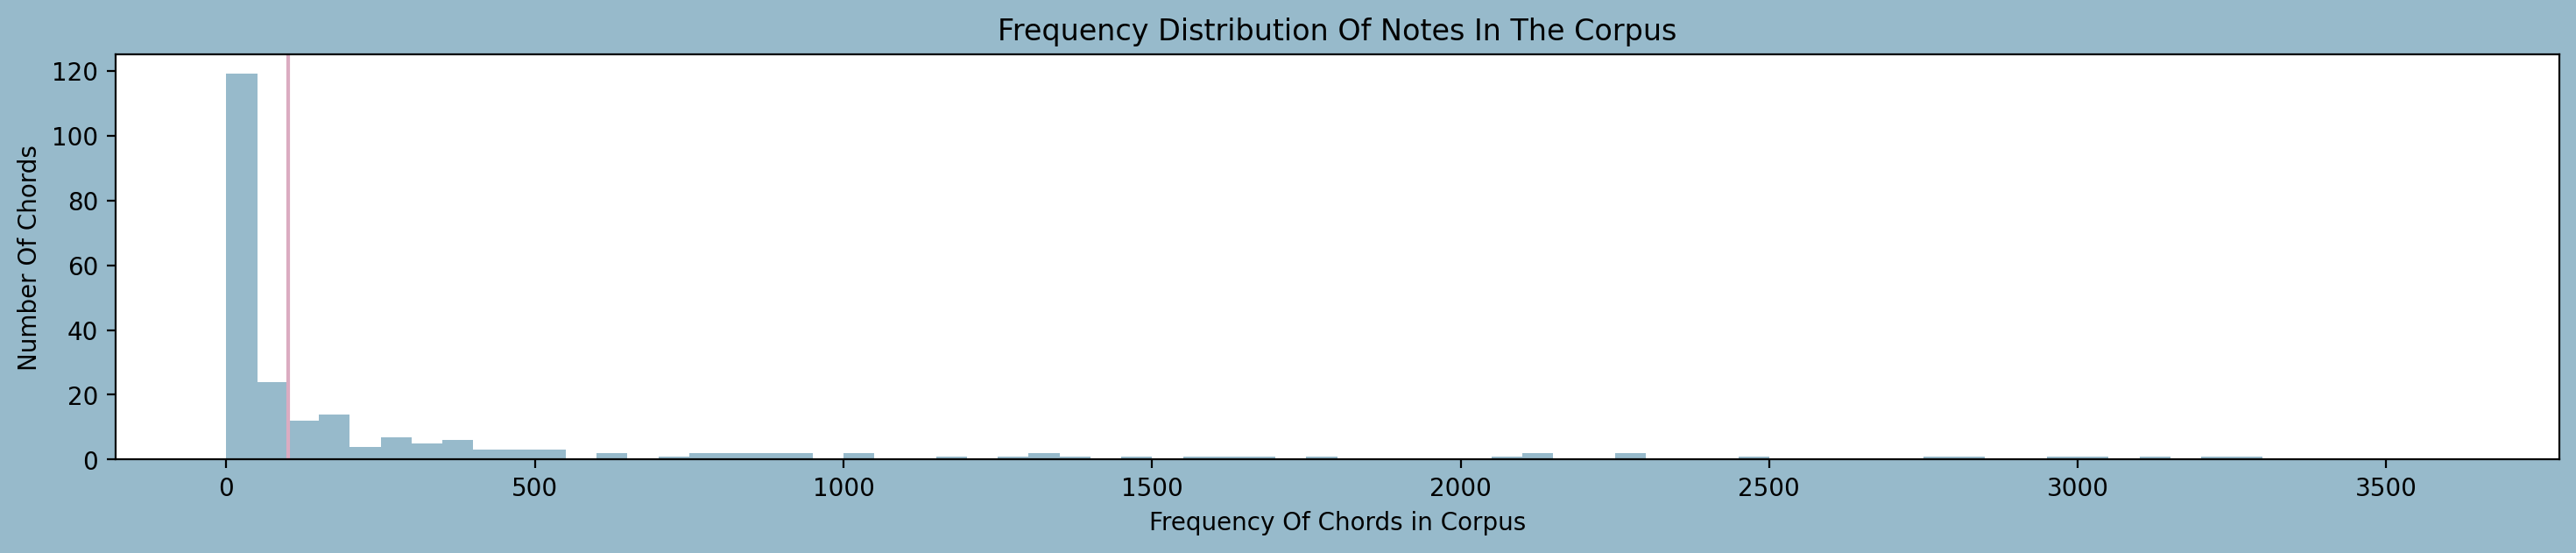

In [ ]:
# Plotting the distribution of Notes
plt.figure(figsize=(18,3),facecolor="#97BACB")
bins = np.arange(0,(max(Recurrence)), 50)
plt.hist(Recurrence, bins=bins, color="#97BACB")
plt.axvline(x=100,color="#DBACC1")
plt.title("Frequency Distribution Of Notes In The Corpus")
plt.xlabel("Frequency Of Chords in Corpus")
plt.ylabel("Number Of Chords")
plt.show()

In [ ]:
#Getting a list of rare chords
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)

print("Total number of notes that occur less than 100 times:", len(rare_note))

Total number of notes that occur less than 100 times: 143


In [ ]:
#Eleminating the rare notes
for element in Corpus:
    if element in rare_note:
        Corpus.remove(element)

print("Length of Corpus after elemination the rare notes:", len(Corpus))

Length of Corpus after elemination the rare notes: 78860


In [ ]:
# Storing all the unique characters present in my corpus to bult a mapping dic.
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 78860
Number of unique characters: 168


In [ ]:
#Splitting the Corpus in equal length of strings and output target
length = 40
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])


L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

Total number of sequences in the Corpus: 78820


In [ ]:
# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)
# one hot encode the output variable
y = tensorflow.keras.utils.to_categorical(targets)

In [ ]:
#Taking out a subset of data to be used as seed
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
def create_model():
  #Initialising the Model
  model = Sequential()
  #Adding layers
  model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
  model.add(Dropout(0.1))
  model.add(LSTM(256))
  model.add(Dense(256))
  model.add(Dropout(0.1))
  model.add(Dense(y.shape[1], activation='softmax'))
  #Compiling the model for training
  opt = Adamax(learning_rate=0.01)
  model.compile(loss='categorical_crossentropy', optimizer=opt)
  return model
model=create_model()

In [ ]:
#Model's Summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 40, 512)           1052672   
                                                                 
 dropout_4 (Dropout)         (None, 40, 512)           0         
                                                                 
 lstm_5 (LSTM)               (None, 256)               787456    
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 168)               43176     
                                                                 
Total params: 1,949,096
Trainable params: 1,949,096
No

In [ ]:
checkpoint_path = "cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tensorflow.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
#Training the Model
history = model.fit(X_train, y_train, batch_size=256, epochs=200)

Epoch 1/200
247/247 [==============================] - 718s 3s/step - loss: 3.9870
Epoch 2/200
247/247 [==============================] - 723s 3s/step - loss: 3.7572
Epoch 3/200
247/247 [==============================] - 720s 3s/step - loss: 3.4969
Epoch 4/200
247/247 [==============================] - 722s 3s/step - loss: 3.2008
Epoch 5/200
247/247 [==============================] - 717s 3s/step - loss: 2.9270
Epoch 6/200
247/247 [==============================] - 703s 3s/step - loss: 2.6754
Epoch 7/200
247/247 [==============================] - 695s 3s/step - loss: 2.4447
Epoch 8/200
247/247 [==============================] - 699s 3s/step - loss: 2.2386
Epoch 9/200
247/247 [==============================] - 708s 3s/step - loss: 2.0604
Epoch 10/200
247/247 [==============================] - 697s 3s/step - loss: 1.8922
Epoch 11/200
 34/247 [===>..........................] - ETA: 10:11 - loss: 1.5841

[Text(0.5, 0, 'Epochs')]

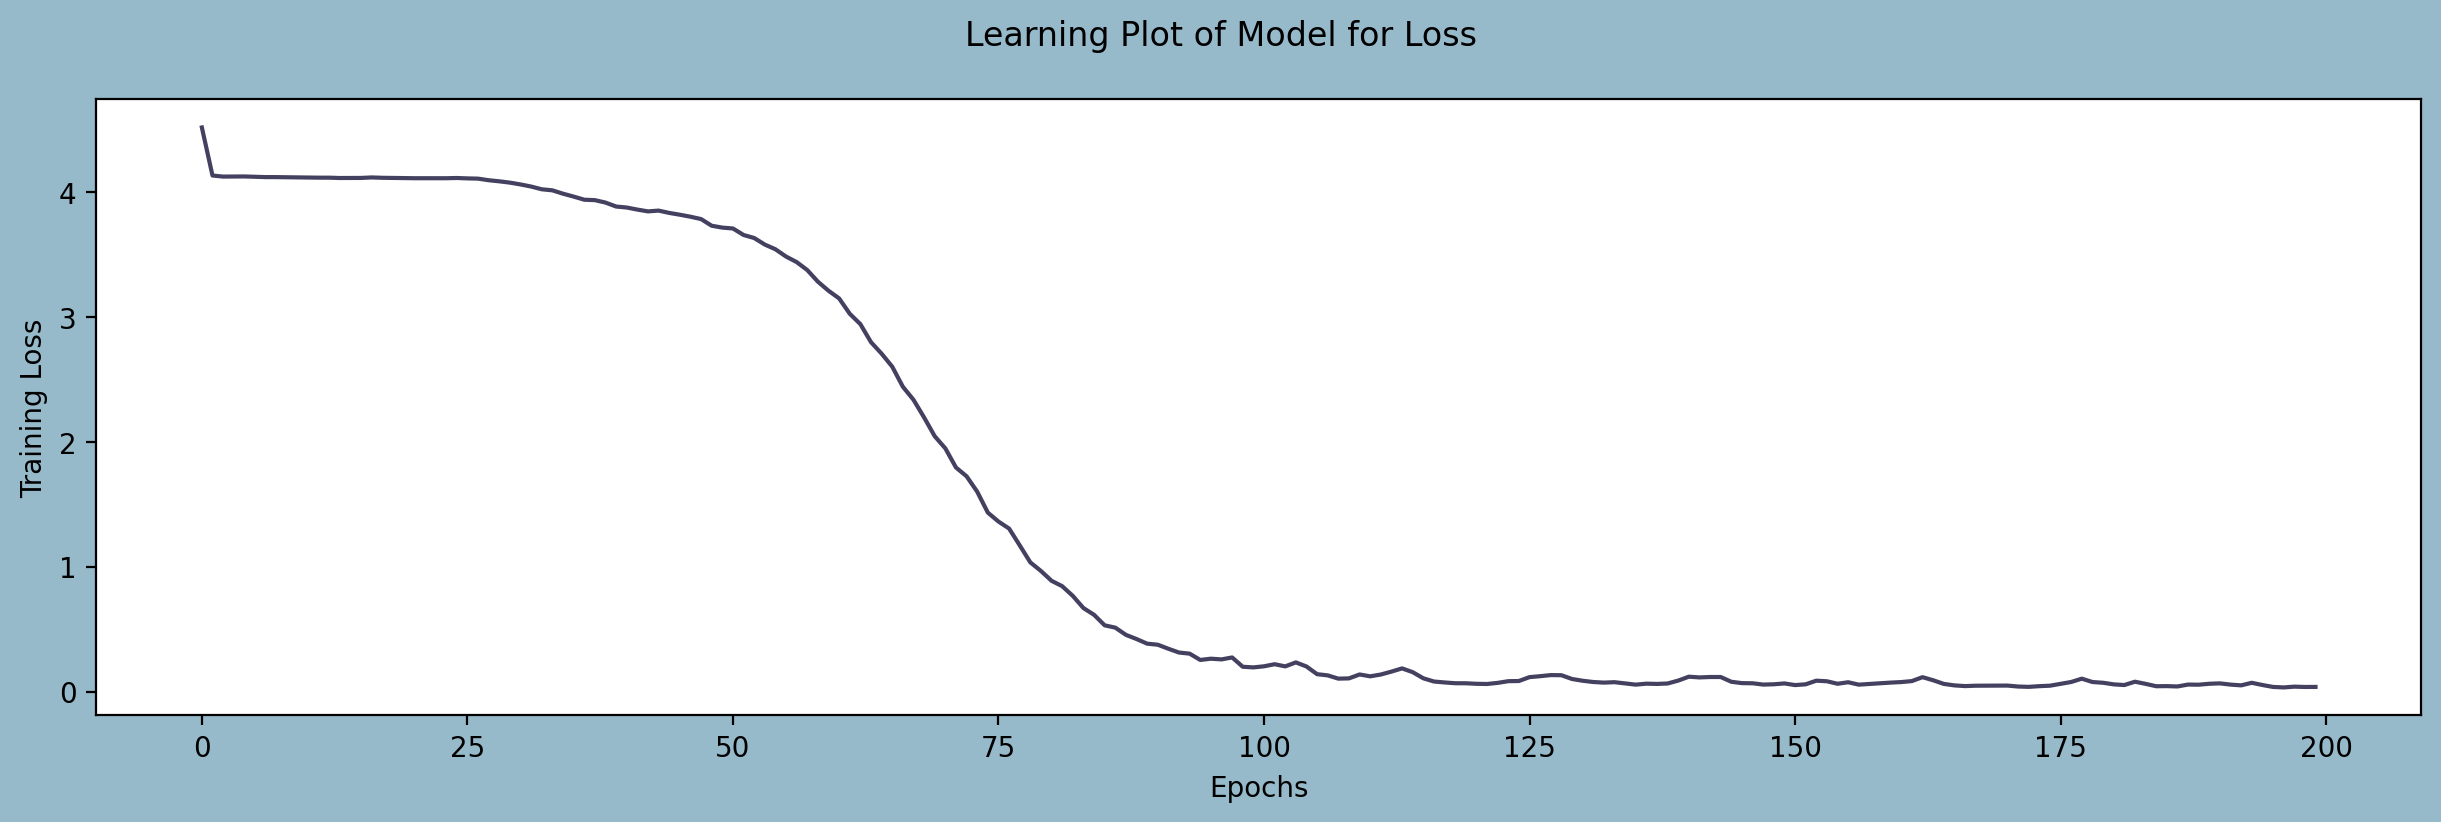

In [ ]:
#Plotting the learnings
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4), facecolor="#97BACB")
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

In [ ]:
import os
from music21 import *

def Malody_Generator(Note_Count):
    seed = X_seed[np.random.randint(0,len(X_seed)-1)]
    Music = ""
    Notes_Generated=[]
    for i in range(Note_Count):
        seed = seed.reshape(1,length,1)
        prediction = model.predict(seed, verbose=0)[0]
        prediction = np.log(prediction) / 1.0 #diversity
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        index = np.argmax(prediction)
        index_N = index/ float(L_symb)
        Notes_Generated.append(index)
        Music = [reverse_mapping[char] for char in Notes_Generated]
        seed = np.insert(seed[0],len(seed[0]),index_N)
        seed = seed[1:]
    #Now, we have music in form or a list of chords and notes and we want to be a midi file.
    Melody = chords_n_notes(Music)
    Melody_midi = stream.Stream(Melody)

    # Save the melody as a MIDI file
    filename = 'generated_music.mid'
    path = os.path.join(os.getcwd(), filename)
    Melody_midi.write('midi', fp=path)

    return Music, Melody_midi


# Generate the music and save it as a MIDI file
Music_notes, Melody = Malody_Generator(100)
print(Melody)

<music21.stream.Stream 0x2d9066800>


In [ ]:
!pip install pygame

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 2.5 MB/s eta 0:00:0000:0100:01


In [ ]:
!pip install midiutil

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 3.1 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for midiutil: filename=MIDIUtil-1.2.1-py3-none-any.whl size=54568 sha256=4b14460ee480f97faa710b68dd4c050d3a3c940c1ca8c27db763ddcfbd96b07d
  Stored in directory: /Users/varundesai/Library/Caches/pip/wheels/43/b1/d7/74d105ea1995b40e71fa97999bcd31926c077a859df2d231a4
Successfully built midiutil
